In [42]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import pandas as pd
import torch
import torch.nn as nn
import timm
from torch import optim
from utils.ProgressBar import ProgressBar
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from MachineLearning.ApartmentsDatasetPyTorch import ApartmentsDatasetPyTorch
from tqdm import tqdm

In [44]:
params = {
    "data_dir" : "../processed_data/data_tiny.csv",
    "images_dir" : '../processed_data/images_tiny',
    "img_input_size" : 256,
    "batch_size" : 32, # because we have a lot of columns
    "shuffle" : False,
    
    "inception_model_output_size" : 256,
    "tabular_ffnn_output_size" : 64,
    "learning_rate" : 1e-3,
    "weight_decay" : 1e-4
}

In [45]:
from DeepLearning.PricePredictionModel import PricePredictionModel

In [46]:
gpu = torch.device("mps:0")

transform = transforms.Compose([
    transforms.Resize((params["img_input_size"], params["img_input_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ApartmentsDatasetPyTorch(
    device = gpu,
    data_dir = params["data_dir"],
    images_dir = params["images_dir"], 
    transform = transform
)
print("Tabular Size", len(dataset.df))
model = PricePredictionModel(
    dataset.tabular_data_size(), 
    params
)
model = model.to(gpu)

Tabular Size 100
Inception output size 256
Tabular output size 64
Regression input size 320


# Training

In [47]:
def custom_collate_fn(batch):
    batch = [data for data in batch if data[-1] == True]
    if not batch:
        return None
    images, datas, prices, is_valid = zip(*batch)
    images = torch.stack(images)#.to(gpu)
    datas = torch.stack(datas)#.to(gpu)
    prices = torch.stack(prices)#.to(gpu)
    
    return images, datas, prices

# Create the dataloader
# dataloader = DataLoader(
#     dataset,
#     batch_size = params["batch_size"],
#     shuffle = params["shuffle"],
#     collate_fn=custom_collate_fn
# )

In [48]:
# Assuming 'dataset' is your full dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
num_epochs = 20
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
num_GPU = 1

train_loader = DataLoader(
    train_dataset,
    batch_size=params["batch_size"], 
    shuffle=params["shuffle"]
)
val_loader = DataLoader(
    val_dataset,
    batch_size=params["batch_size"],
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=params["batch_size"], 
    shuffle=False
)

# Initialize lists to track losses
train_losses = []
val_losses = []

optimizer = optim.Adam(
    model.parameters(), 
    lr=params["learning_rate"],
    weight_decay = params["weight_decay"]
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()

print("Starting training...")
# Training loop with progress bar
for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    for data in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
        images, datas, prices = data
        optimizer.zero_grad()
        outputs = model(images, datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for data in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
            images, datas, prices = data
            outputs = model(images, datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))
        
    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    print(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, L1: {l1_mean_loss}')


Starting training...


Epoch 1/20 - Training:   0%|                             | 0/39 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 3)

In [ ]:
# torch.save(model, "models/model_v5.pth")

In [ ]:
# !conda install --yes pytorch torchvision -c pytorch

In [39]:
import matplotlib.pyplot as plt

train_losses
val_losses

[53063156622.22222,
 38365002638.22222,
 30018304227.555557,
 42767702471.111115,
 30475297564.444443,
 33746709617.77778,
 40125425436.44444,
 32581738154.666668,
 35078289521.77778,
 37152139719.111115,
 33255203498.666668,
 45729989632.0,
 35550254876.44444,
 33256224881.77778,
 34830095360.0,
 34902556046.22222,
 35566453191.111115,
 44122874538.666664,
 38384421888.0,
 38866692323.55556]

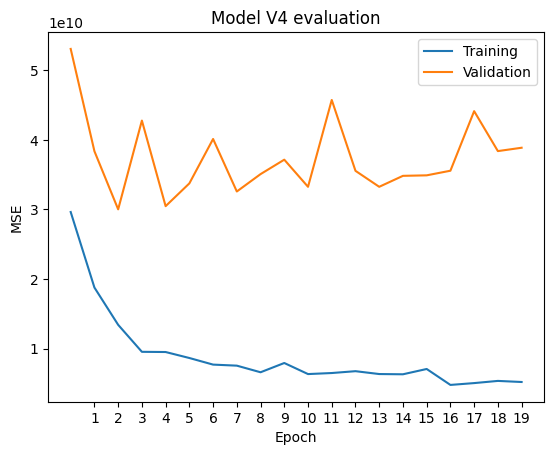

<Figure size 640x480 with 0 Axes>

In [41]:
plt.title("Model V4 evaluation")
plt.plot(train_losses, label = 'Training')
plt.plot(val_losses, label = 'Validation')
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.xticks(range(1, 20))
plt.legend()
plt.show()
plt.savefig('model_v4_epochs.png')